## Case Study 1 

Below is a data set that represents thousands of loans made through the Lending Club platform, which is
a platform that allows individuals to lend to other individuals.
We would like you to perform the following using the language of your choice:

- Describe the dataset and any issues with it.
- Generate a minimum of 5 unique visualizations using the data and write a brief description of
your observations. Additionally, all attempts should be made to make the visualizations visually
appealing
- Create a feature set and create a model which predicts interest_rate using at least 2 algorithms.
Describe any data cleansing that must be performed and analysis when examining the data.
- Visualize the test results and propose enhancements to the model, what would you do if you
had more time. Also describe assumptions you made and your approach.

Disclaimer: Someone who is a essentially a sure bet to pay back a loan will have an easier time getting a loan with a low interest rate than someone who appears to be riskier. And for people who are very risky? They may not even get a loan offer, or they may not have accepted the loan offer due to a high interest rate. It is important to keep that last part in mind, since this data set only represents loans actually made, i.e. do not mistake this data for loan applications!

### Import the required libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import utils

In [2]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


### Loading the data

In [70]:
loans_full_schema = pd.read_csv('loans_full_schema.csv')

In [71]:
loans_full_schema.shape

(10000, 55)

In [72]:
loans_full_schema.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   emp_title                         9167 non-null   object 
 1   emp_length                        9183 non-null   float64
 2   state                             10000 non-null  object 
 3   homeownership                     10000 non-null  object 
 4   annual_income                     10000 non-null  float64
 5   verified_income                   10000 non-null  object 
 6   debt_to_income                    9976 non-null   float64
 7   annual_income_joint               1495 non-null   float64
 8   verification_income_joint         1455 non-null   object 
 9   debt_to_income_joint              1495 non-null   float64
 10  delinq_2y                         10000 non-null  int64  
 11  months_since_last_delinq          4342 non-null   float64
 12  earli

The dataset contains 10000 observations (rows) and 55 variables (columns). Most of the columns are numeric but we also have categorical variables(both ordinal and nominal) and datetime variables.

### Adjust datetime `issue_month` column

In [73]:
loans_full_schema['issue_month'] = pd.to_datetime(loans_full_schema['issue_month'])

In [80]:
loans_full_schema.issue_month.info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: issue_month
Non-Null Count  Dtype         
--------------  -----         
10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 78.2 KB


### Checking for missing values 

In [81]:
loans_full_schema.isnull().sum()

emp_title                            833
emp_length                           817
state                                  0
homeownership                          0
annual_income                          0
verified_income                        0
debt_to_income                        24
annual_income_joint                 8505
verification_income_joint           8545
debt_to_income_joint                8505
delinq_2y                              0
months_since_last_delinq            5658
earliest_credit_line                   0
inquiries_last_12m                     0
total_credit_lines                     0
open_credit_lines                      0
total_credit_limit                     0
total_credit_utilized                  0
num_collections_last_12m               0
num_historical_failed_to_pay           0
months_since_90d_late               7715
current_accounts_delinq                0
total_collection_amount_ever           0
current_installment_accounts           0
accounts_opened_

In [82]:
missing_val_ind = loans_full_schema.isnull().sum().to_numpy().nonzero()
missing_val_ind

(array([ 0,  1,  6,  7,  8,  9, 11, 20, 25, 27], dtype=int64),)

In [83]:
missing_values_count = loans_full_schema.isnull().sum().iloc[missing_val_ind]
missing_values_count.keys()

Index(['emp_title', 'emp_length', 'debt_to_income', 'annual_income_joint',
       'verification_income_joint', 'debt_to_income_joint',
       'months_since_last_delinq', 'months_since_90d_late',
       'months_since_last_credit_inquiry', 'num_accounts_120d_past_due'],
      dtype='object')

The number of the missing values for each feature:

In [12]:
missing_values_count

emp_title                            833
emp_length                           817
debt_to_income                        24
annual_income_joint                 8505
verification_income_joint           8545
debt_to_income_joint                8505
months_since_last_delinq            5658
months_since_90d_late               7715
months_since_last_credit_inquiry    1271
num_accounts_120d_past_due           318
dtype: int64

There are a high percentage of values that is missing for some features: 
```
FEATURE                     % MISSING
'annual_income_joint'       85%,
'verification_income_joint' 85%, 
'debt_to_income_joint'      85%, 
'months_since_last_delinq'  57%, 
'months_since_90d_late'     77%'
```

About these features:
- annual_income_joint = If this is a joint application, then the annual income of the two parties applying 
- verification_income_joint = Type of verification of the joint income, IF joint (40 joint observations without inforamtion about the verification)
- debt_to_income_joint = Debt-to-income ratio for the two parties, IF joint 
- months_since_last_delinq = Months since the last delinquency (behind on payments)

In [93]:
loans_full_schema.application_type.value_counts()[1] / len(loans_full_schema.application_type)

0.1495


They are mostly about the observations with `application_type = joint`, which is about 15% of the total observations. So it is expected to have a lot `nan` values.

### Check for duplicate rows 

In [14]:
print(f'Search for duplicate rows in dataset: {loans_full_schema.duplicated().sum()}')

Search for duplicate rows in dataset: 0


There are no duplicate rows! 

### And now some more details about some important features

In [16]:
loans_full_schema.annual_income.value_counts()

60000.00    383
50000.00    350
65000.00    314
70000.00    273
75000.00    260
           ... 
25560.00      1
63950.00      1
22104.00      1
34415.16      1
96774.00      1
Name: annual_income, Length: 1463, dtype: int64

Range of years of earliest credit line

In [17]:
loans_full_schema.earliest_credit_line.min(), loans_full_schema.earliest_credit_line.max()

(1963, 2015)

Number of current accounts that are 120 and 30 days past due: only 1 for 30 days

In [96]:
loans_full_schema[['num_accounts_120d_past_due', 'num_accounts_30d_past_due']].sum()

num_accounts_120d_past_due    0.0
num_accounts_30d_past_due     1.0
dtype: float64

There are 12 different loan purposes, with the most popoular: 
```
debt_consolidation    5144
credit_card           2249
other                  914
```

In [19]:
loans_full_schema.loan_purpose.value_counts()

debt_consolidation    5144
credit_card           2249
other                  914
home_improvement       680
major_purchase         303
medical                162
house                  151
car                    131
small_business         125
moving                  69
vacation                62
renewable_energy        10
Name: loan_purpose, dtype: int64

#### Basic statistics for :


- the annual income of the observations

In [20]:
loans_full_schema.annual_income.describe().round(2)

count      10000.00
mean       79222.15
std        64734.29
min            0.00
25%        45000.00
50%        65000.00
75%        95000.00
max      2300000.00
Name: annual_income, dtype: float64

- the interest rates of the loans

In [22]:
loans_full_schema.interest_rate.describe().round(2)

count    10000.00
mean        12.43
std          5.00
min          5.31
25%          9.43
50%         11.98
75%         15.05
max         30.94
Name: interest_rate, dtype: float64

- the amount of the loans

In [23]:
loans_full_schema.loan_amount.describe().round(2)

count    10000.00
mean     16361.92
std      10301.96
min       1000.00
25%       8000.00
50%      14500.00
75%      24000.00
max      40000.00
Name: loan_amount, dtype: float64

- debt-to-income ratio

In [25]:
loans_full_schema.debt_to_income.describe()

count    9976.000000
mean       19.308192
std        15.004851
min         0.000000
25%        11.057500
50%        17.570000
75%        25.002500
max       469.090000
Name: debt_to_income, dtype: float64

### 5 Visualizations

It would be interesting to see the interest rate against the loan amount, annual income, grade, history of delayed payment 

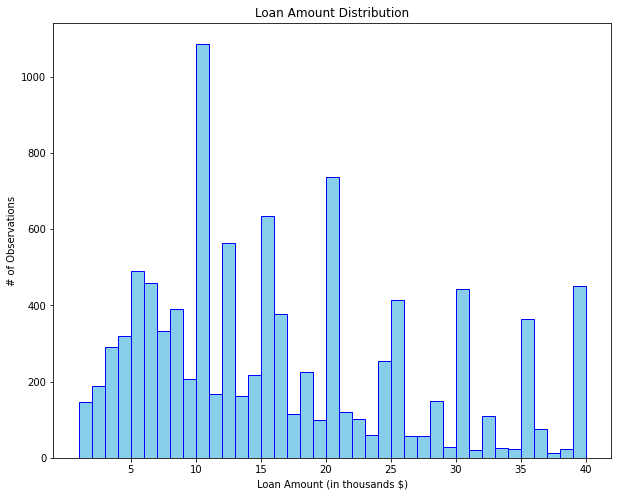

In [98]:
plt.figure(figsize=[10,8])

binsize = 1000
bins = np.arange(loans_full_schema['loan_amount'].min(), loans_full_schema['loan_amount'].max()+binsize, binsize)
plt.hist(data = loans_full_schema, x = 'loan_amount', bins=bins, histtype='barstacked', color='skyblue', ec='blue')
plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount (in thousands $)')
plt.ylabel('# of Observations')
plt.xticks([5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000], ['5','10', '15', '20', '25', '30', '35', '40'])
plt.show()


What we can say about this histogram is that the amounts that are being chosen are amounts that are round numbers.

Most common amount is 10,000 $, approximately 10% of the loans.

Rescale the Loan Amount data, for a more clear distribution

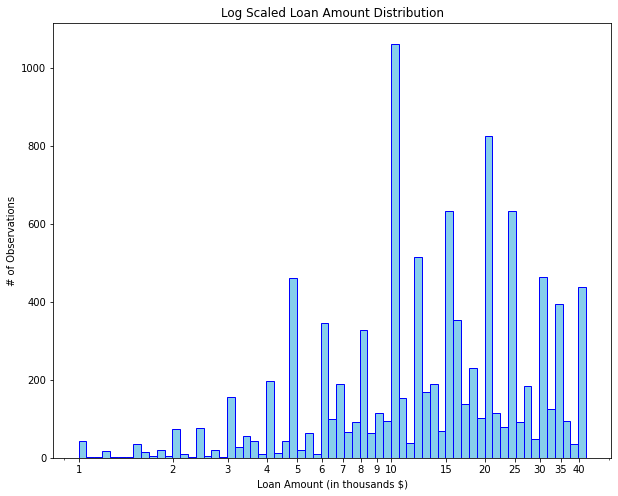

In [99]:
plt.figure(figsize=[10,8])
log_binsize = 0.025
bins = 10 ** np.arange(3, np.log10(loans_full_schema['loan_amount'].max()) + log_binsize, log_binsize)
# plt.subplot(221)
plt.hist(data = loans_full_schema, x = 'loan_amount', bins=bins, histtype='barstacked', color='skyblue', ec='blue')
plt.title('Log Scaled Loan Amount Distribution')
plt.xscale('log')
plt.xlabel('Loan Amount (in thousands $)')
plt.ylabel('# of Observations')
plt.xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 15000, 20000, 25000, 30000, 35000, 40000], ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '15', '20', '25', '30', '35', '40'])
plt.show()


The highest value for a loan amount is between 10K and 20K, while high number we can see between 20K and 30K. 

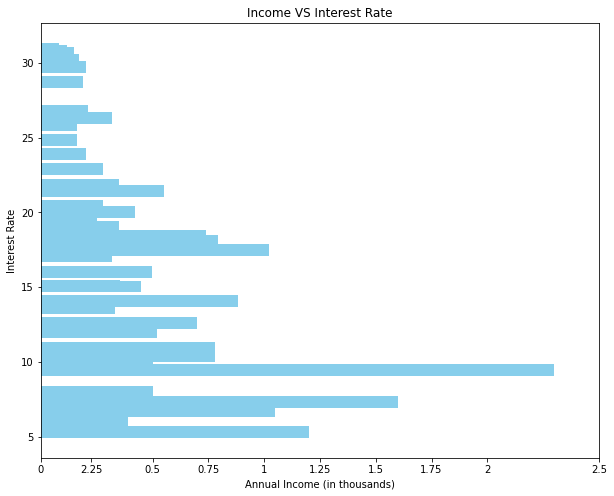

In [100]:
plt.figure(figsize=[10,8])
plt.barh(loans_full_schema.interest_rate, loans_full_schema.annual_income, color = 'skyblue')
plt.title('Income VS Interest Rate')
plt.xlabel('Annual Income (in thousands)')
plt.ylabel('Interest Rate')
plt.xticks([0, 500000, 750000, 1000000, 1250000, 1500000, 1750000, 2000000, 225000, 2500000],['0', '0.5','0.75', '1', '1.25', '1.5', '1.75', '2', '2.25', '2.5'])
plt.show() 


The lower the annual income the higher the interest rate.

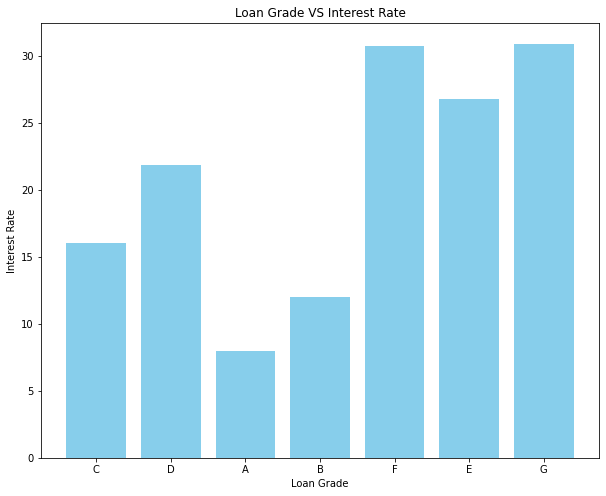

In [30]:
plt.figure(figsize=[10,8])
# plt.subplot(222)
grades = loans_full_schema.grade.value_counts().sort_index()

plt.bar(loans_full_schema.grade, loans_full_schema.interest_rate, color = 'skyblue')
plt.title('Loan Grade VS Interest Rate')
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rate')
plt.show()
 


Lowest Interest Rate for the best Grade A. The rate increases as the grade is getting lower.

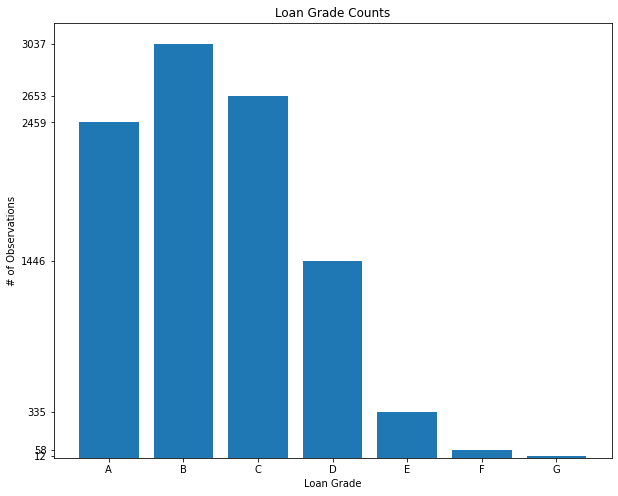

In [101]:
plt.figure(figsize=[10,8])
grades = loans_full_schema.grade.value_counts().sort_index()
ticks = loans_full_schema.grade.value_counts().sort_index()
plt.bar(grades.keys(), grades)
plt.title('Loan Grade Counts')
plt.xlabel('Loan Grade')
plt.ylabel('# of Observations')
plt.xticks(['A', 'B', 'C', 'D', 'E', 'F', 'G'], ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.yticks(ticks=ticks)
plt.show()


Most of the loans made have grade B, then C and A. This is expected since in our data we only have loans that were actually made (hence approved).

Some information about the borrowrers

In [32]:
loans_full_schema.homeownership.value_counts()

MORTGAGE    4789
RENT        3858
OWN         1353
Name: homeownership, dtype: int64

In [33]:
loans_full_schema.verified_income.value_counts()

Source Verified    4116
Not Verified       3594
Verified           2290
Name: verified_income, dtype: int64

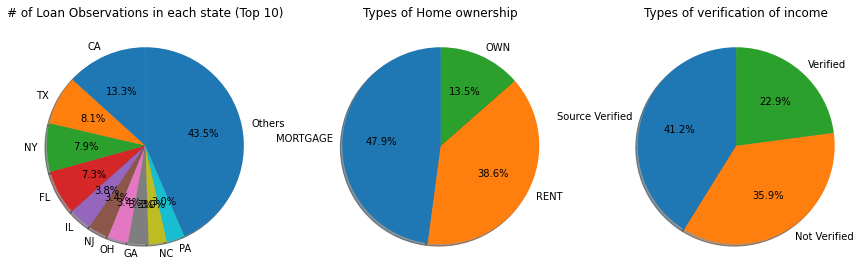

In [102]:
states = loans_full_schema.state.value_counts().sort_values(ascending=False)
states[0:10]
others = pd.Series({'Others': states[10:].sum()})
states_topten = pd.concat([states[0:10],others])

homeownership = loans_full_schema.homeownership.value_counts()
verified = loans_full_schema.verified_income.value_counts()

plt.figure(figsize = [15,15])
plt.subplot(1,3,1)
plt.pie(states_topten, labels = states_topten.keys(), autopct='%1.1f%%' , shadow=True, startangle=90)
plt.title('# of Loan Observations in each state (Top 10)')

plt.subplot(1,3,2)
plt.pie(homeownership, labels=homeownership.keys(), autopct='%1.1f%%',startangle=90, shadow=True)
plt.title('Types of Home ownership')

plt.subplot(1,3,3)
plt.pie(verified, labels=verified.keys(), autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Types of verification of income')

plt.show()

#  THIS COULD BE A PIE CHART WITH THE STATES 
#  or a bar chart 

- Top 5 states that have made loans: 
    ```
    CA        1330 
    TX         806
    NY         793
    FL         732
    IL         382
    ```
- Almost 50% have a mortgage for their home, and 40% live on rent 
- A bit more than 1/3 of observations' incomes in not verified 

#### Below are some general descriptions of features that I think play some important role to the outcome (approval / disapproval) of the loan. 

In [35]:
loans_full_schema.total_debit_limit.describe().round(2)

count     10000.00
mean      27357.41
std       26570.16
min           0.00
25%       10000.00
50%       19500.00
75%       36100.00
max      386700.00
Name: total_debit_limit, dtype: float64

In [36]:
loans_full_schema.account_never_delinq_percent.describe().round(2)

count    10000.00
mean        94.65
std          9.16
min         14.30
25%         92.60
50%        100.00
75%        100.00
max        100.00
Name: account_never_delinq_percent, dtype: float64

In [37]:
loans_full_schema.term.value_counts()

36    6970
60    3030
Name: term, dtype: int64

The length of the loan is either 36 months (3 years) or 60 months (5 years)

In [38]:
loans_full_schema.loan_status.value_counts()

Current               9375
Fully Paid             447
In Grace Period         67
Late (31-120 days)      66
Late (16-30 days)       38
Charged Off              7
Name: loan_status, dtype: int64

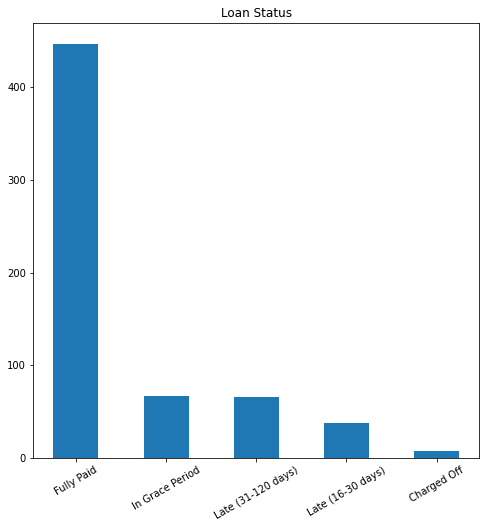

In [103]:
status = loans_full_schema.loan_status.value_counts()
status  = status.drop('Current')

plt.figure(figsize=[8,8])
plt.bar(status.keys(), status, width=5*[0.5])
plt.xticks(rotation = 30)
plt.title('Loan Status')
plt.show()

But with the "Current" bar being way higher than the others, we can focus on the other 4 status

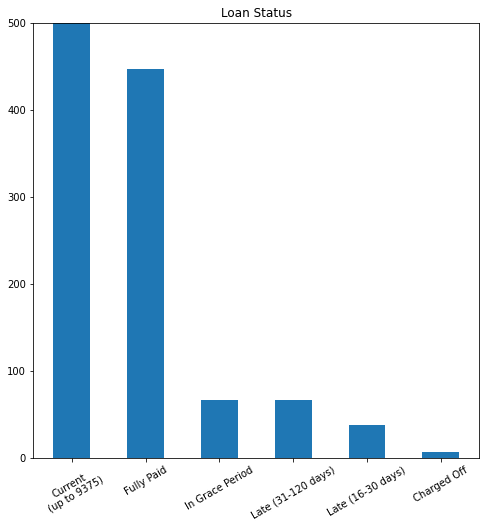

In [104]:
status = np.array(loans_full_schema.loan_status.value_counts().keys())
status[0] = status[0] + '\n (up to 9375)'
plt.figure(figsize=[8,8])
plt.bar(status, loans_full_schema.loan_status.value_counts(), width=6*[0.5])
plt.ylim(top = 500)
plt.xticks(status, rotation = 30)
plt.title('Loan Status')
plt.show()

- Fully Paid only 4% 
- Late (16-30 days) 4%
- Late (31-120 days) 7%
- Charged Off 0,1% 


In [42]:
loans_full_schema.initial_listing_status.value_counts()

whole         8206
fractional    1794
Name: initial_listing_status, dtype: int64

Amounts paid for 4 important categories: amount of loan paid, amount left, intest paid, late fees paid

In [43]:
loans_full_schema[['paid_total','paid_principal', 'paid_interest', 'paid_late_fees']].head(10)

,paid_total,paid_principal,paid_interest,paid_late_fees
0,1999.33,984.14,1015.19,0.0
1,499.12,348.63,150.49,0.0
2,281.80,175.37,106.43,0.0
3,3312.89,2746.74,566.15,0.0
4,2324.65,1569.85,754.80,0.0
5,873.13,743.29,129.84,0.0
6,2730.51,1440.00,1290.51,0.0
7,1765.84,994.61,771.23,0.0
8,2703.22,1843.34,859.88,0.0
9,391.15,322.87,68.28,0.0


### Predicting the Interest Rate

#### I am going to get rid of 45 features that aren't useful for predicting the interest rate


The features that I keep: 
- 'annual_income',
- 'debt_to_income',
- 'delinq_2y',
- 'num_historical_failed_to_pay',
- 'loan_amount',
- 'interest_rate',
- 'installment',
- 'grade', 
- 'sub_grade',
- 'balance',

In [46]:
prediction_features = loans_full_schema.drop(['emp_title', 'emp_length', 'state', 'homeownership', 'verified_income', 'annual_income_joint',
       'verification_income_joint', 'debt_to_income_joint', 'months_since_last_delinq', 'earliest_credit_line',
       'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines',
       'total_credit_limit', 'total_credit_utilized',
       'num_collections_last_12m',
       'months_since_90d_late', 'current_accounts_delinq',
       'total_collection_amount_ever', 'current_installment_accounts',
       'accounts_opened_24m', 'months_since_last_credit_inquiry',
       'num_satisfactory_accounts', 'num_accounts_120d_past_due',
       'num_accounts_30d_past_due', 'num_active_debit_accounts',
       'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts',
       'num_cc_carrying_balance', 'num_mort_accounts',
       'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt',
       'loan_purpose', 'application_type',  'term',
        'issue_month', 'loan_status', 'initial_listing_status', 'disbursement_method',
        'paid_total', 'paid_principal', 'paid_interest',
       'paid_late_fees'], axis=1)

prediction_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   annual_income                 10000 non-null  float64
 1   debt_to_income                9976 non-null   float64
 2   delinq_2y                     10000 non-null  int64  
 3   num_historical_failed_to_pay  10000 non-null  int64  
 4   loan_amount                   10000 non-null  int64  
 5   interest_rate                 10000 non-null  float64
 6   installment                   10000 non-null  float64
 7   grade                         10000 non-null  object 
 8   sub_grade                     10000 non-null  object 
 9   balance                       10000 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 781.4+ KB


Grade and Sub-grade are not numeric data

In [47]:
loans_full_schema.grade.value_counts().sort_index()

A    2459
B    3037
C    2653
D    1446
E     335
F      58
G      12
Name: grade, dtype: int64

In [48]:
loans_full_schema.sub_grade.value_counts().sort_index()

A1    422
A2    480
A3    504
A4    568
A5    485
B1    647
B2    638
B3    540
B4    581
B5    631
C1    597
C2    572
C3    501
C4    503
C5    480
D1    319
D2    323
D3    311
D4    231
D5    262
E1     41
E2     57
E3     73
E4     73
E5     91
F1     31
F2      9
F3      9
F4      5
F5      4
G1     11
G4      1
Name: sub_grade, dtype: int64

for now I am dropping the grade & subgrade columns 

In [49]:
prediction_features.drop([ 'grade', 'sub_grade'], axis = 1, inplace=True)


In [50]:
prediction_features

,annual_income,debt_to_income,delinq_2y,num_historical_failed_to_pay,loan_amount,interest_rate,installment,balance
0,90000.0,18.01,0,0,28000,14.07,652.53,27015.86
1,40000.0,5.04,0,1,5000,12.61,167.54,4651.37
2,40000.0,21.15,0,0,2000,17.09,71.40,1824.63
3,30000.0,10.16,0,1,21600,6.72,664.19,18853.26
4,35000.0,57.96,0,0,23000,14.07,786.87,21430.15
...,...,...,...,...,...,...,...,...
9995,108000.0,22.28,0,1,24000,7.35,744.90,21586.34
9996,121000.0,32.38,4,0,10000,19.03,366.72,9147.44
9997,67000.0,45.26,2,0,30000,23.88,1175.10,27617.65
9998,80000.0,11.99,0,0,24000,5.32,722.76,21518.12


In [51]:
652.53/18.01

36.23153803442531

In [52]:
652.53/ 7500

0.087004

In [53]:
prediction_features[prediction_features['debt_to_income'].isnull()]


,annual_income,debt_to_income,delinq_2y,num_historical_failed_to_pay,loan_amount,interest_rate,installment,balance
154,0.0,NaN,2,0,20000,17.09,498.02,19128.86
927,0.0,NaN,0,0,5200,10.41,168.80,4825.70
1255,0.0,NaN,1,0,24000,17.47,602.55,23229.44
1330,0.0,NaN,0,0,15000,7.35,465.57,13872.03
1653,0.0,NaN,1,0,30400,20.39,1135.83,28510.40
1718,0.0,NaN,0,0,27800,9.43,889.61,25764.48
1845,0.0,NaN,0,0,32000,20.39,854.77,31050.95
2106,1.0,NaN,0,0,10000,7.97,313.23,8749.43
2546,0.0,NaN,0,0,18000,13.58,611.54,16741.91
2556,0.0,NaN,0,0,18000,15.05,624.42,16375.07


In [54]:
prediction_features[prediction_features.annual_income == 0]


,annual_income,debt_to_income,delinq_2y,num_historical_failed_to_pay,loan_amount,interest_rate,installment,balance
154,0.0,NaN,2,0,20000,17.09,498.02,19128.86
927,0.0,NaN,0,0,5200,10.41,168.80,4825.70
1255,0.0,NaN,1,0,24000,17.47,602.55,23229.44
1330,0.0,NaN,0,0,15000,7.35,465.57,13872.03
1653,0.0,NaN,1,0,30400,20.39,1135.83,28510.40
1718,0.0,NaN,0,0,27800,9.43,889.61,25764.48
1845,0.0,NaN,0,0,32000,20.39,854.77,31050.95
2546,0.0,NaN,0,0,18000,13.58,611.54,16741.91
2556,0.0,NaN,0,0,18000,15.05,624.42,16375.07
3429,0.0,NaN,0,0,11000,28.72,347.29,10743.90


There are 24 rows missing the debt_to_income input, so I will drop these rows

In [55]:
prediction_features.dropna(inplace=True)

In [56]:
prediction_features.shape

(9976, 8)

Now we have 9976 observations and 8 features 

#### Find a model to predict interest rate

In [57]:
x_train = prediction_features.drop('interest_rate',axis=1)
x_train

,annual_income,debt_to_income,delinq_2y,num_historical_failed_to_pay,loan_amount,installment,balance
0,90000.0,18.01,0,0,28000,652.53,27015.86
1,40000.0,5.04,0,1,5000,167.54,4651.37
2,40000.0,21.15,0,0,2000,71.40,1824.63
3,30000.0,10.16,0,1,21600,664.19,18853.26
4,35000.0,57.96,0,0,23000,786.87,21430.15
...,...,...,...,...,...,...,...
9995,108000.0,22.28,0,1,24000,744.90,21586.34
9996,121000.0,32.38,4,0,10000,366.72,9147.44
9997,67000.0,45.26,2,0,30000,1175.10,27617.65
9998,80000.0,11.99,0,0,24000,722.76,21518.12


Split the data needed for predictions in 60% training, 20% cross validation, 20% test

In [58]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(prediction_features.drop('interest_rate', axis=1), prediction_features.interest_rate, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

In [59]:
del x_, y_
print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (5985, 7)
the shape of the training set (target) is: (5985,)

the shape of the cross validation set (input) is: (1995, 7)
the shape of the cross validation set (target) is: (1995,)

the shape of the test set (input) is: (1996, 7)
the shape of the test set (target) is: (1996,)


In [60]:
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays

Normalize the training data

In [61]:
scaler = StandardScaler()
x_norm = scaler.fit_transform(x_train)
print(f"Peak to Peak range by column in Raw        X:{np.ptp(x_train,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(x_norm,axis=0)}")

Peak to Peak range by column in Raw        X:annual_income                   2297000.00
debt_to_income                      469.09
delinq_2y                            13.00
num_historical_failed_to_pay          7.00
loan_amount                       39000.00
installment                        1535.84
balance                           40000.00
dtype: float64
Peak to Peak range by column in Normalized X:[33.71 30.32 18.98 15.87  3.79  5.21  4.02]


Create Regression Model

In [62]:
sgdr = SGDRegressor(max_iter=1000)
sgdr.fit(x_norm, y_train)
print(sgdr)
print(f"number of iterations completed: {sgdr.n_iter_}, number of weight updates: {sgdr.t_}")

SGDRegressor()
number of iterations completed: 12, number of weight updates: 71821.0


In [63]:
b_norm = sgdr.intercept_
w_norm = sgdr.coef_
print(f"model parameters:                   w: {w_norm}, b:{b_norm}")

model parameters:                   w: [-0.75  0.32  0.51  0.27 -1.01  1.48  0.18], b:[12.46]


In [64]:
# make a prediction using sgdr.predict()
y_pred_sgd = sgdr.predict(x_norm)
# make a prediction using w,b. 
y_pred = np.dot(x_norm, w_norm) + b_norm  
print(f"prediction using np.dot() and sgdr.predict match: {(y_pred == y_pred_sgd).all()}")

print(f"Prediction on training set:\n{y_pred[:4]}" )
print(f"Target values \n{y_train[:4]}")

prediction using np.dot() and sgdr.predict match: True
Prediction on training set:
[11.53 13.15 11.6  14.43]
Target values 
1004     5.31
8987     6.07
2862     6.72
2371    18.06
Name: interest_rate, dtype: float64


C:\Users\evi_9\AppData\Local\Temp\ipykernel_26556\135825059.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(f"Target values \n{y_train[:4]}")


In [65]:
x_features = prediction_features.columns
x_features

Index(['annual_income', 'debt_to_income', 'delinq_2y',
       'num_historical_failed_to_pay', 'loan_amount', 'interest_rate',
       'installment', 'balance'],
      dtype='object')

C:\Users\evi_9\AppData\Local\Temp\ipykernel_26556\451965641.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax[i].scatter(x_norm[:100,i], y_train[:100], label = 'target',)


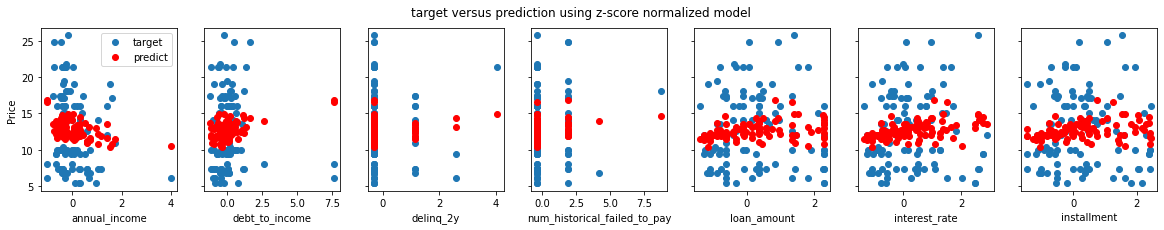

In [67]:
# plot predictions and targets vs original features    
fig,ax=plt.subplots(1,7,figsize=(20,3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(x_norm[:100,i], y_train[:100], label = 'target',)
    ax[i].set_xlabel(x_features[i])
    ax[i].scatter(x_norm[:100,i],y_pred[:100],color='red', label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

This is not a good model to predict the interest rate. If I had more time I would try: 
- feature engineering and polynomial regression
- cross validation tests to see what I can modify to get a better model
- getting rid of features that do not help with predicting the target value (interest rate)